# Model-1 Testing

The aim of this notebook is to test Model-1 against the original test datasets chosen to evaluate this model, namely; Gab, Reddit, Twitter. This notebook does provide test results to Gab_reddit_test dataset to differentiate its performances. Here, the model class is defined under the monomer of RoLnn. The class is identitical to that of the original fine-tuning notebook. The saved model is loaded into the file using torch.load from the file path in the drive. This notebook finally demonstrates the comparison ROC-AUC curves and a confusion matrix for the Gab_reddit dataset. 

## Part 1: Data Preparation
- Loading data to fine-tune using Huggingface's load_dataset module
- Loading Gab, Reddit and Twitter datasets using load_dataset module


## Part 2: Model class definition
- Load the tokenizer for the chosen model
- Definition of the model with the pre-trained layer, Bidirectional LSTM and CNN layer to generate the necessary classified output
- Loading saved model into the cuda device

## Part 3: Gab test
- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 75 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Subset the misclassified data
- Creating word cloud to visualise the words appearing in misclassified data
- Plotting the ROC-AUC

## Part 4: Reddit Test
- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 30 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Subset the misclassified data
- Creating word cloud to visualise the words appearing in misclassified data
- Plotting the ROC-AUC

## Part 5: Twitter Test

- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 120 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Plotting the ROC-AUC

## Part 6: Comparison

- Plotting of a comparison ROC-AUC for Gab, Reddit and Twitter

## Part 7: Gab_reddit Test

- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 100 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'


# Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.2 MB/s eta 0:00:00


In [ ]:
#import all necessary modules
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

from torch.utils.data import DataLoader
from datasets import load_metric
from tqdm.auto import tqdm


## Load test datasets

In [ ]:
reddit= load_dataset('csv',data_files='cleaned_reddit4.csv')
twitter = load_dataset('csv',data_files='cleaned_tweets01.csv')
gab = load_dataset('csv',data_files='gab_again2.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Model Definition

In [ ]:
#downloading the model
checkpoint = "cardiffnlp/twitter-roberta-base-hate-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512

In [ ]:
# define the model class RoLnn (RoBERTa+BiLSTM+CNN)
class RoLnn(nn.Module):
  def __init__(self, checkpoint, num_labels):
    super(RoLnn, self).__init__()
    self.num_labels = num_labels

    # Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_attentions=True, output_hidden_states=True))
    self.dropout = nn.Dropout(0.1)

    # Add BiLSTM layers
    hidden_size = 768
    num_layers = 2
    self.bilstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)

    # Add CNN layer
    kernel_size = 3
    self.cnn = nn.Conv1d(hidden_size * 2, hidden_size, kernel_size)

    self.classifier = nn.Linear(hidden_size, num_labels)  # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None, Label=None):
    # Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    # Add custom layers
    sequence_output = self.dropout(outputs[0])  # outputs[0]=last hidden state

    # Apply BiLSTM
    lstm_output, _ = self.bilstm(sequence_output)

    # Apply CNN
    lstm_output = lstm_output.permute(0, 2, 1)  # Reshape for Conv1d
    cnn_output = self.cnn(lstm_output)
    cnn_output = cnn_output.permute(0, 2, 1)  # Reshape back to original

    logits = self.classifier(cnn_output[:, -1, :])  # calculate losses

    loss = None
    if Label is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), Label.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # to save the outputs in device cuda
model=RoLnn(checkpoint=checkpoint,num_labels=2).to(device)#save the model with the checkpoint from huggingface

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate-latest and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/bert+lstm+cnn2.pt')) #Load the saved fine-tuned model from drive location

<All keys matched successfully>

# Gab Test

In [ ]:
#setting format
gab.set_format('pandas')
gab=gab['train'][:]
gab=Dataset.from_pandas(gab)
gab = DatasetDict({'test':gab})
gab

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'Content', 'Label'],
        num_rows: 3007
    })
})

In [ ]:
def delete_null_rows(dataset_dict):
    for key, dataset in dataset_dict.items():
        null_indices = [idx for idx, row in enumerate(dataset) if any(value is None for value in row.values())]
        dataset = dataset.select([i for i in range(len(dataset)) if i not in null_indices])
        dataset_dict[key] = dataset
    return dataset_dict

In [ ]:
#remove unnamed column and delete any null rows
gab = gab.remove_columns('Unnamed: 0')
delete_null_rows(gab)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 3007
    })
})

In [ ]:
def tokenize(batch):
    return tokenizer(batch["Content"], truncation=True, max_length=max_length)


In [ ]:
max_length=75
gab_t = gab.map(tokenize, batched=True)

Map:   0%|          | 0/3007 [00:00<?, ? examples/s]

In [ ]:
metric1 = load_metric("f1")
metric2 = load_metric("accuracy")
metric3 = load_metric("precision")

<ipython-input-21-a2ab371a20f1>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("f1")


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
#testing gab dataset
gab_t.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
dataloader = DataLoader(
    gab_t["test"], batch_size=8, collate_fn=data_collator
)

model.eval()


progress_bar_eval = tqdm(range(1 * len(dataloader)))


for batch in dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_g= torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_g, references=batch["Label"])
    metric2.add_batch(predictions=predictions_g, references=batch["Label"])
    metric3.add_batch(predictions=predictions_g, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/376 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.2585278276481149}
{'accuracy': 0.7253076155636847}
{'precision': 0.16017797552836485}


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
#to print confusion matrix
gab_predictions2=[]
gab_true_labels2=[]

model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_g = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        gab_predictions2.extend(predictions_g.cpu().numpy())
        gab_true_labels2.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
gab_predictions2 = np.array(gab_predictions2)
gab_true_labels2 = np.array(gab_true_labels2)

In [ ]:
confusion_matrix = confusion_matrix(gab_true_labels2, gab_predictions2)
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=["True no_hate", "True hate"], columns=["Pred no_hate", "Pred hate"])
print(confusion_matrix_df)

              Pred no_hate  Pred hate
True no_hate          2037        755
True hate               71        144


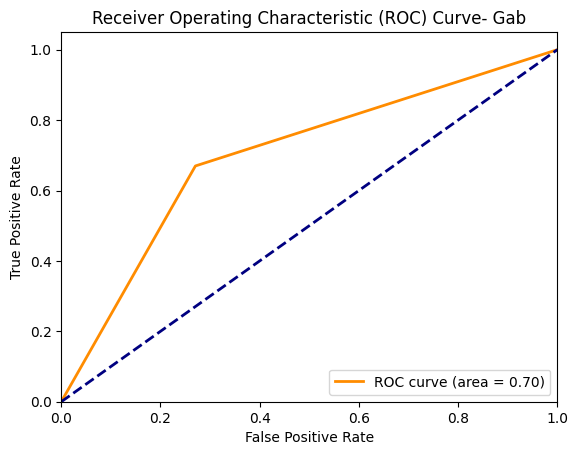

In [ ]:
fpr_g, tpr_g, thresholds = roc_curve(gab_true_labels2, gab_predictions2)
roc_auc_gab = roc_auc_score(gab_true_labels2, gab_predictions2)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Gab')
plt.legend(loc='lower right')
plt.show()

In [ ]:
df_g = pd.read_csv('gab_again2.csv')
df_g.drop(columns='Unnamed: 0',inplace=True)
df_g['Predicted'] = gab_predictions2

In [ ]:
df_g

,Content,Label,Predicted
0,most valuable alt righter,0,1
1,this is a good science group here on gab,0,0
2,down boris down boy no boris come here its not...,0,0
3,the british people are at war with the invadin...,1,1
4,out of the members who make up this deepstate...,0,0
...,...,...,...
3002,laughing out loud this cyph person who diliber...,1,1
3003,oh how i wish whatever could be united by our ...,0,0
3004,i left them long ago as well i never posted a...,0,1
3005,music for britfam,0,1


In [ ]:
misclassification = df_g.loc[(df_g['Label']==1)&(df_g['Predicted']==0)]
misclassification

,Content,Label,Predicted
138,now i know why the ruling class acts like what...,1,0
247,by the way you have no clue what religion or r...,1,0
304,right on erasing americas culture and heritage...,1,0
358,socialism is a mental disorder really sociali...,1,0
389,sorry my child my name is really satan not all...,1,0
...,...,...,...
2849,if the japanese do not accept refugees they ar...,1,0
2885,i have heard people say that mohammed tastes l...,1,0
2943,parent over shoulder senator leahy sounds like...,1,0
2956,taylor swift goes full libtard,1,0


In [ ]:
mis_2 = df_g.loc[(df_g['Label']==0)&(df_g['Predicted']==1)]

In [ ]:
misclassification = pd.concat([misclassification,mis_2])
misclassification

,Content,Label,Predicted
138,now i know why the ruling class acts like what...,1,0
247,by the way you have no clue what religion or r...,1,0
304,right on erasing americas culture and heritage...,1,0
358,socialism is a mental disorder really sociali...,1,0
389,sorry my child my name is really satan not all...,1,0
...,...,...,...
2993,uss liberty truth video featuring a marine who...,0,1
2996,why do they think their opinion matters,0,1
2997,gym sign upsets fat people,0,1
3004,i left them long ago as well i never posted a...,0,1


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

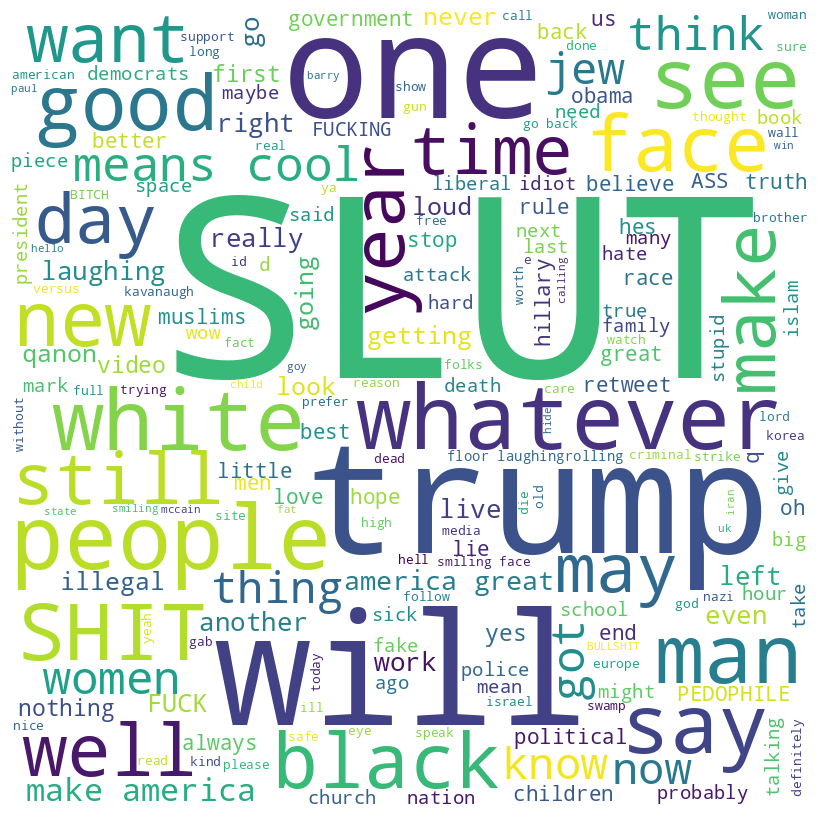

In [ ]:
text = ' '.join(mis_2['Content'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
mis_3 = misclassification.loc[(misclassification['Predicted']==0) & (misclassification['Label']==1)]

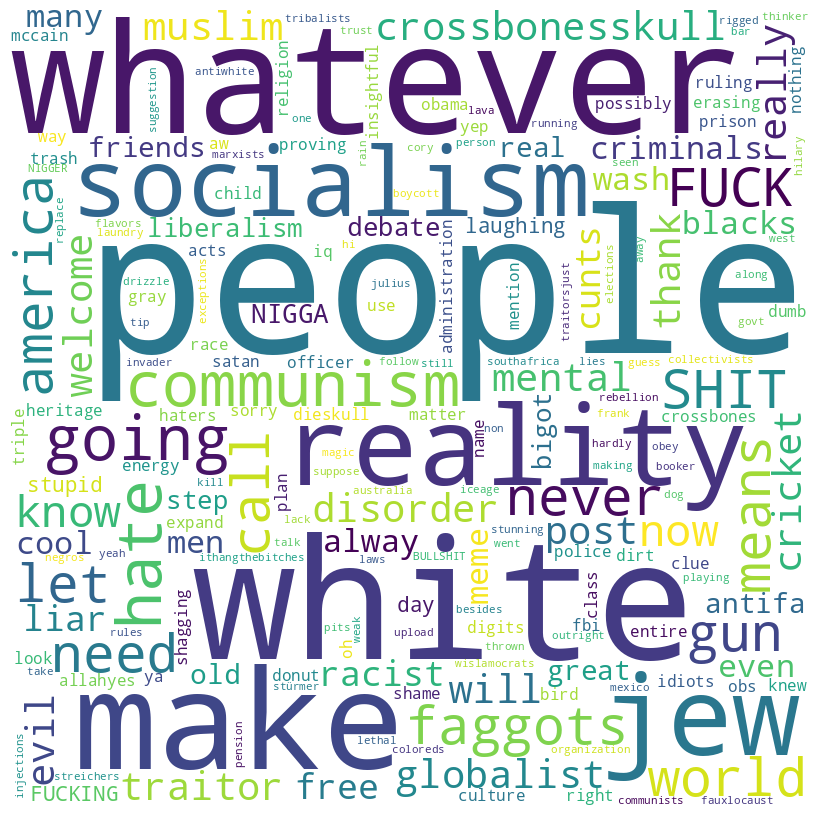

In [ ]:
text2 = ' '.join(mis_3['Content'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(text2)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
misclassification.to_csv('misclassification_gab.csv')

# Reddit test

In [ ]:
reddit.set_format('pandas')
reddit=reddit['train'][:]
reddit=Dataset.from_pandas(reddit)
reddit = DatasetDict({'test':reddit})
reddit = reddit.remove_columns('Unnamed: 0')
delete_null_rows(reddit)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 2117
    })
})

In [ ]:
max_length=30
tokenized_reddit = reddit.map(tokenize, batched=True)
tokenized_reddit

Map:   0%|          | 0/2117 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 2117
    })
})

In [ ]:
tokenized_reddit.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
reddit_dataloader = DataLoader(
    tokenized_reddit["test"], batch_size=16, collate_fn=data_collator
)

In [ ]:
model.eval()


progress_bar_eval = tqdm(range(1 * len(reddit_dataloader)))


for batch in reddit_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_reddit = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric2.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric3.add_batch(predictions=predictions_reddit, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/133 [00:00<?, ?it/s]

{'f1': 0.3324538258575198}
{'accuracy': 0.6414737836561172}
{'precision': 0.2747093023255814}


In [ ]:
reddit_predictions=[]
reddit_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in reddit_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_reddit = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        reddit_predictions.extend(predictions_reddit.cpu().numpy())
        reddit_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
reddit_predictions = np.array(reddit_predictions)
reddit_true_labels = np.array(reddit_true_labels)

In [ ]:
confusion_matrixr = confusion_matrix(reddit_true_labels, reddit_predictions)
confusion_matrix_r = pd.DataFrame(confusion_matrixr, index=["True no_hate", "True hate"], columns=["Pred no_hate", "Pred hate"])
print(confusion_matrix_r)

              Pred no_hate  Pred hate
True no_hate          1169        499
True hate              260        189


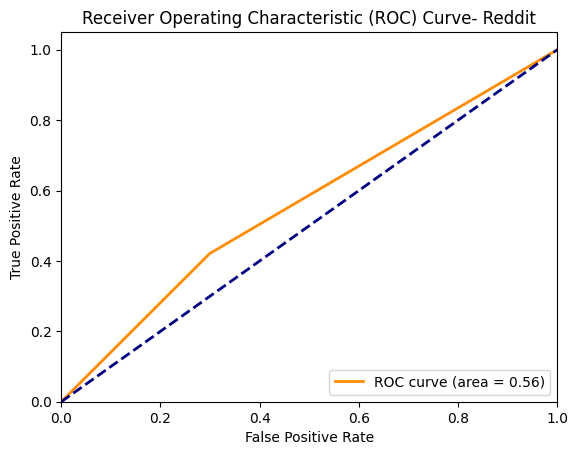

In [ ]:
fpr3, tpr3, thresholds = roc_curve(reddit_true_labels, reddit_predictions)
roc_auc_reddit = roc_auc_score(reddit_true_labels, reddit_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_reddit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Reddit')
plt.legend(loc='lower right')
plt.show()

In [ ]:
df_r = pd.read_csv('cleaned_reddit4.csv')
df_r.drop(columns ='Unnamed: 0',inplace=True)


In [ ]:
df_r['predictions'] = reddit_predictions

In [ ]:
mis_r = df_r.loc[(df_r['Label']==1) &(df_r['predictions']==0)]
mis_r2 = df_r.loc[(df_r['Label']==0) &(df_r['predictions']==1)]

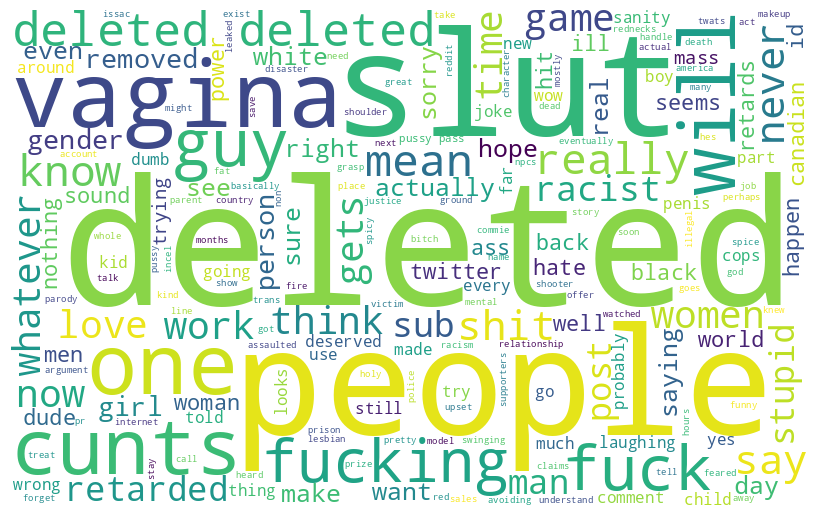

In [ ]:
text_r = ' '.join(mis_r['Content'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',
                      min_font_size=6).generate(text_r)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

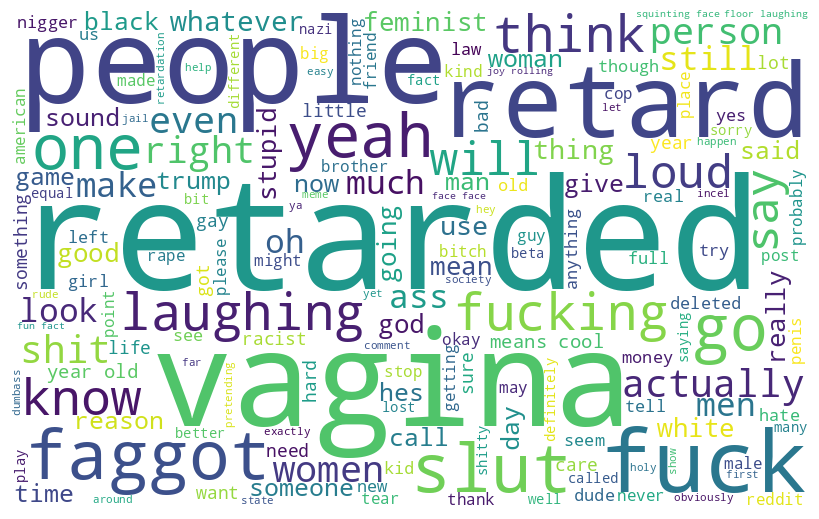

In [ ]:
text_r2 = ' '.join(mis_r2['Content'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500,
                      background_color='white',
                      min_font_size=10).generate(text_r2)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
misclassification_r = pd.concat([mis_r,mis_r2])

In [ ]:
misclassification_r.to_csv('misclassification_reddit.csv')

# Twitter test

In [ ]:
twitter.set_format('pandas')
twitter=twitter['train'][:]
twitter=Dataset.from_pandas(twitter)
twitter = DatasetDict({'test':twitter})
twitter = twitter.remove_columns('Unnamed: 0')
delete_null_rows(twitter)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 1118
    })
})

In [ ]:
max_length= 120
tokenized_twitter = twitter.map(tokenize, batched=True)


Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

In [ ]:
tokenized_twitter.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
twitter_dataloader = DataLoader(
    tokenized_twitter["test"], batch_size=8, collate_fn=data_collator
)

In [ ]:
model.eval()


progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


for batch in twitter_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_twitter = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_twitter, references=batch["Label"])
    metric2.add_batch(predictions=predictions_twitter, references=batch["Label"])
    metric3.add_batch(predictions=predictions_twitter, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/140 [00:00<?, ?it/s]

{'f1': 0.7792642140468229}
{'accuracy': 0.8819320214669052}
{'precision': 0.7467948717948718}


In [ ]:
all_predictions=[]
all_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in twitter_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_twitter = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        all_predictions.extend(predictions_twitter.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

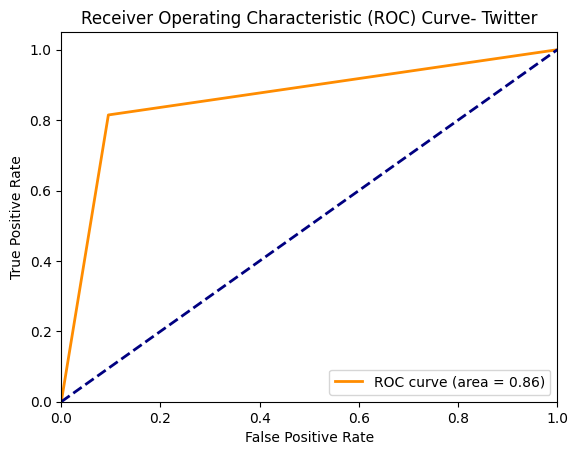

In [ ]:
fpr1, tpr1, thresholds = roc_curve(all_true_labels, all_predictions)
roc_auc = roc_auc_score(all_true_labels, all_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Twitter')
plt.legend(loc='lower right')
plt.show()

## Comparison curve

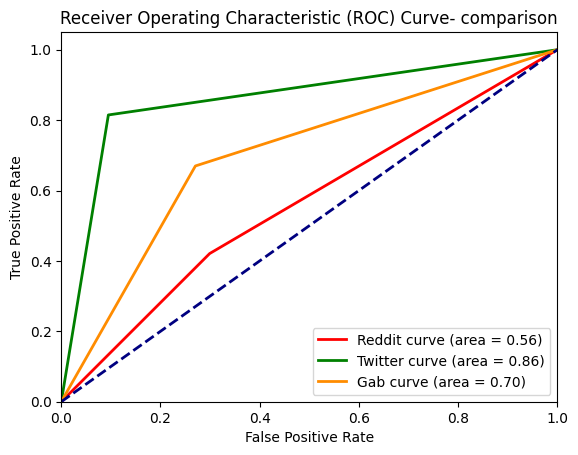

In [ ]:
plt.figure()
plt.plot(fpr3, tpr3, color='red', lw=2, label='Reddit curve (area = %0.2f)' % roc_auc_reddit)
plt.plot(fpr1, tpr1, color='green', lw=2, label='Twitter curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='Gab curve (area = %0.2f)' % roc_auc_gab)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- comparison')
plt.legend(loc='lower right')
plt.show()

## Gab_reddit Test

In [ ]:
gabb_reddit=load_dataset("csv",data_files="/content/drive/My Drive/gabb_reddit_test.csv")
gabb_reddit

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 8910
    })
})

In [ ]:
gabb_reddit.set_format('pandas')
gabb_reddit=gabb_reddit['train'][:]
gabb_reddit=Dataset.from_pandas(gabb_reddit)

In [ ]:
gabb_reddit = DatasetDict({
    'test': gabb_reddit
    })

In [ ]:
gabb_reddit

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 8910
    })
})

In [ ]:
delete_null_rows(gabb_reddit)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 8822
    })
})

In [ ]:
max_length = 100
tokens_gr = gabb_reddit.map(tokenize, batched = True)

Map:   0%|          | 0/8822 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader
tokens_gr.set_format("torch",columns=["input_ids", "attention_mask", "Label"])

gr_dataloader = DataLoader(
    tokens_gr["test"], batch_size=16, collate_fn=data_collator
)

In [ ]:


model.eval()


progress_bar_eval = tqdm(range(1 * len(gr_dataloader)))


for batch in gr_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_gr= torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_gr, references=batch["Label"])
    metric2.add_batch(predictions=predictions_gr, references=batch["Label"])
    metric3.add_batch(predictions=predictions_gr, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/552 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.7496702716961223}
{'accuracy': 0.7848560417138971}
{'precision': 0.7437843496466894}


In [ ]:
import numpy as np

In [ ]:
gr_predictions=[]
gr_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in gr_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_gr = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        gr_predictions.extend(predictions_gr.cpu().numpy())
        gr_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
gr_predictions = np.array(gr_predictions)
gr_true_labels = np.array(gr_true_labels)

In [ ]:
confusion_m = confusion_matrix(gr_true_labels, gr_predictions)
confusion_matrix_r = pd.DataFrame(confusion_m, index=["True no_hate", "True hate"], columns=["Pred no_hate", "Pred hate"])
print(confusion_matrix_r)

              Pred no_hate  Pred hate
True no_hate          4082        979
True hate              919       2842
